In [3]:
import os
import imutils
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
from PIL import Image
import tensorflow as tf

In [4]:
tf.test.is_built_with_cuda()

True

In [5]:
tf.test.gpu_device_name()

''

In [6]:
DATASET_ROOT = '../data/processed'
DATASET_TRAIN = DATASET_ROOT + '/train'
DATASET_TEST = DATASET_ROOT + '/test'

SAVED_MODELS_PATH = '../saved_models'

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        DATASET_TRAIN,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        DATASET_TEST,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 1615 images belonging to 3 classes.
Found 283 images belonging to 3 classes.


In [8]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

def vgg16_based_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(150, 150, 3)))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x, name='vgg16_based')
    return model


def residual_block(x, filters_num):
    x_residual = x
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters_num, (3, 3), padding='same')(x)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters_num, (3, 3), padding='same')(x)
    
    x = tf.keras.layers.add([x, x_residual])
    
    return x


def downsample(x, filters_num):
    x = Conv2D(filters_num, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    return x


def resnet_simple_model():
    model_input = Input(shape=(150, 150, 3))
    x = BatchNormalization()(model_input)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    x = downsample(x, 128)
    
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    
    x = downsample(x, 128)
    
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    
    x = downsample(x, 64)
    
#     x = residual_block(x, 64)
#     x = residual_block(x, 64)
    
    x = Flatten(name='flatten')(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=model_input, outputs=x, name='simple_residual')
    return model
              
    
model = resnet_simple_model()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "simple_residual"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 150, 150, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 150, 64) 1792        batch_normalization[0][0]        
__________________________________________________________________________________________________
activation (Activation)         (None, 150, 150, 64) 0           conv2d[0][0]                     
____________________________________________________________________________________

In [9]:
from datetime import datetime
time_now = datetime.now().strftime('%Y_%m_%d__%H_%M_%S')
path_to_save = SAVED_MODELS_PATH + '/' + model.name + '_' + time_now

cp_callback = tf.keras.callbacks.ModelCheckpoint(path_to_save, save_best_only=True)

In [10]:
model.fit_generator(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=1000000,
        validation_data=validation_generator,
        validation_steps=STEP_SIZE_VALID,
        callbacks=[cp_callback])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 17 steps
Epoch 1/1000000
 99/100 [============================>.] - ETA: 0s - loss: 1.5186 - accuracy: 0.5092WARNING:tensorflow:From /home/jakub/code/covid-19/env/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../saved_models/simple_residual_2020_05_01__21_58_00/assets
100/100 [==============================] - 110s 1s/step - loss: 1.5162 - accuracy: 0.5103 - val_loss: 2.3478 - val_accuracy: 0.2978
Epoch 2/1000000
100/100 [==============================] - 104s 1s/step - loss: 0.9703 - accuracy: 0.5485 - val_loss: 0.948

Epoch 37/1000000
100/100 [==============================] - 95s 954ms/step - loss: 0.7880 - accuracy: 0.6679 - val_loss: 0.6972 - val_accuracy: 0.7500
Epoch 38/1000000
100/100 [==============================] - 95s 952ms/step - loss: 0.7460 - accuracy: 0.6723 - val_loss: 0.6917 - val_accuracy: 0.7243
Epoch 39/1000000
100/100 [==============================] - 95s 952ms/step - loss: 0.7550 - accuracy: 0.6604 - val_loss: 0.7911 - val_accuracy: 0.7169
Epoch 40/1000000
100/100 [==============================] - 95s 955ms/step - loss: 0.7633 - accuracy: 0.6673 - val_loss: 0.7105 - val_accuracy: 0.7243
Epoch 41/1000000
100/100 [==============================] - 95s 953ms/step - loss: 0.7800 - accuracy: 0.6529 - val_loss: 0.8002 - val_accuracy: 0.6691
Epoch 42/1000000
100/100 [==============================] - 95s 950ms/step - loss: 0.7822 - accuracy: 0.6235 - val_loss: 0.7667 - val_accuracy: 0.6691
Epoch 43/1000000
100/100 [==============================] - 96s 956ms/step - loss: 0.7600 - ac

Epoch 89/1000000
100/100 [==============================] - 95s 948ms/step - loss: 0.7132 - accuracy: 0.6967 - val_loss: 0.7027 - val_accuracy: 0.7132
Epoch 90/1000000
100/100 [==============================] - 96s 955ms/step - loss: 0.7025 - accuracy: 0.6898 - val_loss: 0.6897 - val_accuracy: 0.7059
Epoch 91/1000000
100/100 [==============================] - 96s 957ms/step - loss: 0.7049 - accuracy: 0.7054 - val_loss: 0.6955 - val_accuracy: 0.7096
Epoch 92/1000000
100/100 [==============================] - 96s 959ms/step - loss: 0.6899 - accuracy: 0.7061 - val_loss: 0.6999 - val_accuracy: 0.7132
Epoch 93/1000000
100/100 [==============================] - 95s 946ms/step - loss: 0.7146 - accuracy: 0.6929 - val_loss: 0.6983 - val_accuracy: 0.7059
Epoch 94/1000000
100/100 [==============================] - 95s 946ms/step - loss: 0.6908 - accuracy: 0.7061 - val_loss: 0.7704 - val_accuracy: 0.7316
Epoch 95/1000000
100/100 [==============================] - 106s 1s/step - loss: 0.7029 - accu

100/100 [==============================] - 96s 959ms/step - loss: 0.5924 - accuracy: 0.7486 - val_loss: 0.6768 - val_accuracy: 0.7463
Epoch 138/1000000
100/100 [==============================] - 94s 940ms/step - loss: 0.5747 - accuracy: 0.7655 - val_loss: 0.6854 - val_accuracy: 0.7647
Epoch 139/1000000
100/100 [==============================] - 96s 958ms/step - loss: 0.5652 - accuracy: 0.7649 - val_loss: 0.6299 - val_accuracy: 0.7757
Epoch 140/1000000
100/100 [==============================] - 95s 955ms/step - loss: 0.5812 - accuracy: 0.7649 - val_loss: 0.7564 - val_accuracy: 0.7390
Epoch 141/1000000
100/100 [==============================] - 96s 957ms/step - loss: 0.5752 - accuracy: 0.7711 - val_loss: 0.7703 - val_accuracy: 0.7647
Epoch 142/1000000
100/100 [==============================] - 95s 950ms/step - loss: 0.5793 - accuracy: 0.7749 - val_loss: 0.6565 - val_accuracy: 0.7537
Epoch 143/1000000
100/100 [==============================] - 94s 940ms/step - loss: 0.5874 - accuracy: 0.7

Epoch 189/1000000
100/100 [==============================] - 96s 958ms/step - loss: 0.5065 - accuracy: 0.7899 - val_loss: 0.5754 - val_accuracy: 0.7647
Epoch 190/1000000
100/100 [==============================] - 95s 951ms/step - loss: 0.5343 - accuracy: 0.7842 - val_loss: 0.6904 - val_accuracy: 0.8015
Epoch 191/1000000
100/100 [==============================] - 96s 956ms/step - loss: 0.4875 - accuracy: 0.8011 - val_loss: 0.6087 - val_accuracy: 0.8015
Epoch 192/1000000
100/100 [==============================] - 95s 952ms/step - loss: 0.4857 - accuracy: 0.8024 - val_loss: 0.8640 - val_accuracy: 0.7721
Epoch 193/1000000
100/100 [==============================] - 96s 959ms/step - loss: 0.4930 - accuracy: 0.8136 - val_loss: 0.5721 - val_accuracy: 0.7868
Epoch 194/1000000
100/100 [==============================] - 95s 951ms/step - loss: 0.5241 - accuracy: 0.7880 - val_loss: 0.6091 - val_accuracy: 0.7647
Epoch 195/1000000
100/100 [==============================] - 95s 947ms/step - loss: 0.47

Epoch 242/1000000
100/100 [==============================] - 95s 952ms/step - loss: 0.3862 - accuracy: 0.8493 - val_loss: 0.6332 - val_accuracy: 0.8235
Epoch 243/1000000
100/100 [==============================] - 96s 957ms/step - loss: 0.4030 - accuracy: 0.8412 - val_loss: 0.8430 - val_accuracy: 0.8088
Epoch 244/1000000
100/100 [==============================] - 95s 954ms/step - loss: 0.4359 - accuracy: 0.8361 - val_loss: 0.6293 - val_accuracy: 0.8235
Epoch 245/1000000
100/100 [==============================] - 94s 944ms/step - loss: 0.3925 - accuracy: 0.8368 - val_loss: 0.9475 - val_accuracy: 0.8015
Epoch 246/1000000
100/100 [==============================] - 94s 940ms/step - loss: 0.3913 - accuracy: 0.8424 - val_loss: 0.6766 - val_accuracy: 0.8125
Epoch 247/1000000
100/100 [==============================] - 94s 937ms/step - loss: 0.3815 - accuracy: 0.8450 - val_loss: 0.6253 - val_accuracy: 0.8162
Epoch 248/1000000
100/100 [==============================] - 95s 948ms/step - loss: 0.38

Epoch 296/1000000
100/100 [==============================] - 95s 948ms/step - loss: 0.2759 - accuracy: 0.8887 - val_loss: 0.7807 - val_accuracy: 0.8015
Epoch 297/1000000
100/100 [==============================] - 95s 946ms/step - loss: 0.3113 - accuracy: 0.8705 - val_loss: 0.8274 - val_accuracy: 0.8125
Epoch 298/1000000
100/100 [==============================] - 96s 956ms/step - loss: 0.2658 - accuracy: 0.8999 - val_loss: 0.6099 - val_accuracy: 0.7978
Epoch 299/1000000
100/100 [==============================] - 95s 952ms/step - loss: 0.2695 - accuracy: 0.8949 - val_loss: 0.8326 - val_accuracy: 0.8346
Epoch 300/1000000
100/100 [==============================] - 94s 939ms/step - loss: 0.2964 - accuracy: 0.8799 - val_loss: 0.6871 - val_accuracy: 0.8199
Epoch 301/1000000
100/100 [==============================] - 95s 947ms/step - loss: 0.2751 - accuracy: 0.8943 - val_loss: 0.9793 - val_accuracy: 0.8199
Epoch 302/1000000
100/100 [==============================] - 95s 949ms/step - loss: 0.26

Epoch 350/1000000
100/100 [==============================] - 95s 953ms/step - loss: 0.1855 - accuracy: 0.9287 - val_loss: 0.9018 - val_accuracy: 0.8235
Epoch 351/1000000
100/100 [==============================] - 95s 953ms/step - loss: 0.1926 - accuracy: 0.9337 - val_loss: 1.0203 - val_accuracy: 0.8235
Epoch 352/1000000
100/100 [==============================] - 94s 939ms/step - loss: 0.1954 - accuracy: 0.9243 - val_loss: 0.9390 - val_accuracy: 0.8309
Epoch 353/1000000
100/100 [==============================] - 95s 946ms/step - loss: 0.1979 - accuracy: 0.9362 - val_loss: 0.9575 - val_accuracy: 0.8162
Epoch 354/1000000
100/100 [==============================] - 95s 954ms/step - loss: 0.2087 - accuracy: 0.9275 - val_loss: 1.2382 - val_accuracy: 0.7978
Epoch 355/1000000
100/100 [==============================] - 95s 950ms/step - loss: 0.2035 - accuracy: 0.9212 - val_loss: 0.9127 - val_accuracy: 0.7831
Epoch 356/1000000
100/100 [==============================] - 95s 955ms/step - loss: 0.23

InternalError: GPU sync failed

In [9]:
validation_generator.class_indices

{'covid19': 0, 'normal': 1, 'pneumonia': 2}

In [10]:
validation_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int32)

In [11]:
model = tf.keras.models.load_model(
    SAVED_MODELS_PATH + '/' + 'simple_residual_2020_05_01__21_58_00', custom_objects=None, compile=True
)

In [12]:
preds = model.predict(validation_generator)
preds

array([[8.39236259e-01, 3.45706604e-02, 1.26193032e-01],
       [6.27018452e-01, 9.65304822e-02, 2.76450962e-01],
       [1.92986384e-01, 4.96838987e-02, 7.57329702e-01],
       [6.49531245e-01, 8.93131420e-02, 2.61155695e-01],
       [4.56081122e-01, 1.56729087e-01, 3.87189806e-01],
       [2.08050806e-05, 9.99507189e-01, 4.72011045e-04],
       [1.73253730e-01, 2.12451726e-01, 6.14294529e-01],
       [2.91299112e-02, 9.16204989e-01, 5.46650924e-02],
       [2.78259702e-02, 8.08551311e-01, 1.63622722e-01],
       [5.89504659e-01, 1.08902387e-01, 3.01592946e-01],
       [9.79541719e-01, 2.96395877e-03, 1.74943041e-02],
       [9.86485481e-01, 1.08893705e-03, 1.24255894e-02],
       [8.39862134e-03, 9.30850625e-01, 6.07508272e-02],
       [6.02468729e-01, 1.04577340e-01, 2.92953908e-01],
       [7.94432104e-01, 1.11042578e-02, 1.94463596e-01],
       [1.85788915e-01, 2.82863587e-01, 5.31347513e-01],
       [8.58429015e-01, 2.96802800e-02, 1.11890651e-01],
       [8.25128436e-01, 3.82498

In [13]:
preds > 0.5

array([[ True, False, False],
       [ True, False, False],
       [False, False,  True],
       [ True, False, False],
       [False, False, False],
       [False,  True, False],
       [False, False,  True],
       [False,  True, False],
       [False,  True, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [False,  True, False],
       [ True, False, False],
       [ True, False, False],
       [False, False,  True],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [False, False,  True],
       [ True, False, False],
       [ True, False, False],
       [False, False,  True],
       [ True, False, False],
       [False, False, False],
       [ True, False, False],
       [False, False, False],
       [ True, False, False],
       [ True, False, False],
       [False, False,  True],
       [ True, False, False],
       [ True, False, False],
       [False,  True, False],
       [Fa

In [14]:
preds_classes = np.argmax(preds, axis=1)

In [15]:
validation_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int32)

In [16]:
preds_classes

array([0, 0, 2, 0, 0, 1, 2, 1, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 2, 0, 0,
       2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2,
       2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2])

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

cf = confusion_matrix(validation_generator.classes, preds_classes) #, labels=["covid19", "normal", "pneumonia"])
cf

array([[ 21,   4,   7],
       [  1, 132,  17],
       [  1,  19,  81]])

In [18]:
report = classification_report(validation_generator.classes, preds_classes, target_names=["covid19", "normal", "pneumonia"])
print(report)

              precision    recall  f1-score   support

     covid19       0.91      0.66      0.76        32
      normal       0.85      0.88      0.87       150
   pneumonia       0.77      0.80      0.79       101

    accuracy                           0.83       283
   macro avg       0.85      0.78      0.81       283
weighted avg       0.83      0.83      0.83       283



In [19]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
#     plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    return plt

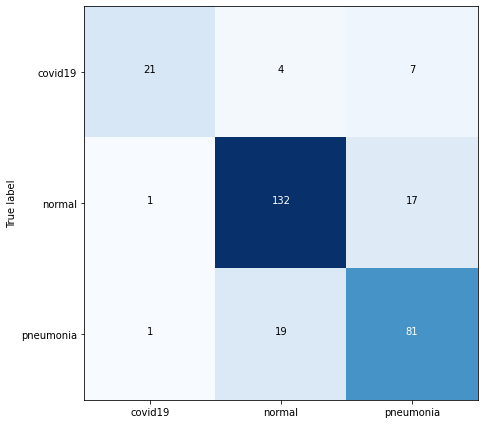

In [20]:
plt = plot_confusion_matrix(cm = cf, 
                      normalize    = False,
                      target_names = ["covid19", "normal", "pneumonia"],
                      title        = "")
plt.savefig('../docs/' + model.name + '.png')